<a href="https://colab.research.google.com/github/soobook/TensorFlow-DL/blob/main/code/TF10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 10회차: CNN을 활용한 컬러 이미지 분류 (4) – 모델 최적화

## 한글 처리와 그림 선명하게

In [ ]:
!pip install koreanize-matplotlib
import koreanize_matplotlib
%config InlineBackend.figure_format = 'retina'

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 37.7 MB/s eta 0:00:00


## 패션 MNIST 분류 CNN 고급 코드

In [ ]:
# ===== 라이브러리 임포트 =====
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, Input
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

In [ ]:
# ===== 1. 데이터 로딩 및 전처리 =====
fashion_mnist = tf.keras.datasets.fashion_mnist
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# 정규화 및 채널 차원 추가
x_train = x_train[..., np.newaxis] / 255.0
x_test = x_test[..., np.newaxis] / 255.0

# 클래스 이름 정의
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


### 함수 compute_class_weight()로 클래스 불균형(class imbalance) 문제 해결
- 불균형 클래스 비율을 고려해 각 클래스별 가중치(weight)를 계산
	- class_weight='balanced': 자동으로 클래스 수에 반비례하는 가중치 부여
	- 내부 수식
    > ```클래스 j의 가중치(w_j) = 			전체 샘플 수 / (클래스 수 × 클래스 j의 샘플 수)```
- 학습 fit() 반영
  - 클래스 불균형(class imbalance)”을 보정하는 핵심 매개변수
  - 손실(loss) 계산 시 클래스별로 다른 중요도(weight)를 곱해줘서, 데이터가 적은 클래스도 학습에서 충분히 반영되도록 해줌
```python
    # ===== 9. 학습 수행 =====
    history = model.fit(
        train_ds,                     # 훈련 데이터셋 (tf.data 형태, 증강 포함)
        validation_data=val_ds,       # 검증 데이터셋 (증강 없음)
        epochs=30,                    # 총 30번 훈련 반복
        class_weight=class_weights,   # 클래스 불균형 보정용 가중치
        callbacks=[lr_reduction]      # 학습률 조정 콜백 (ReduceLROnPlateau)
    )
```

In [ ]:
# ===== 2. 클래스 불균형 보정 =====
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(class_weight='balanced',
                                     classes=np.unique(y_train),
                                     y=y_train)
class_weights = dict(enumerate(class_weights))
class_weights

{0: np.float64(1.0),
 1: np.float64(1.0),
 2: np.float64(1.0),
 3: np.float64(1.0),
 4: np.float64(1.0),
 5: np.float64(1.0),
 6: np.float64(1.0),
 7: np.float64(1.0),
 8: np.float64(1.0),
 9: np.float64(1.0)}

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# 예시: 실제 데이터의 클래스 레이블
# (예: 0, 1, 2 중에서 0이 많고, 2가 가장 적은 불균형 데이터)
y = np.array([0, 0, 0, 0, 1, 1, 2])

# 클래스 목록
classes = np.unique(y)

# 클래스별 가중치 계산
weights = compute_class_weight(
    class_weight='balanced',  # 'balanced'로 하면 자동으로 비율 계산
    classes=classes,
    y=y
)

# 결과 출력
for cls, w in zip(classes, weights):
    print(f"Class {cls}: weight = {w:.3f}")

Class 0: weight = 0.583
Class 1: weight = 1.167
Class 2: weight = 2.333


### 학습 데이터를 학습과 검증 데이터로 분할
- 모델 성능을 객관적으로 평가하기 위해 학습  데이터를 검증용으로 따로 분리하는 과정
- 과적합(overfitting)을 감지하거나 하이퍼파라미터(학습율 등) 튜닝에 활용
  - test_size=0.1: 10%를 검증용으로 사용, 나머지 90%는 학습에 사용
  - stratify=y_train: 클래스 불균형이 있는 경우, 클래스 비율이 학습/검증 데이터 모두에서 동일하게 유지
    - 고양이:강아지 = 8:2 라면 → 학습/검증셋 모두 이 비율로 구성


In [ ]:
# ===== 3. 학습/검증 데이터 분할 =====
from sklearn.model_selection import train_test_split
x_train_sub, x_val, y_train_sub, y_val = train_test_split(
    x_train, y_train, test_size=0.1, stratify=y_train, random_state=42)

In [ ]:
from collections import Counter
Counter(y_train)

Counter({np.uint8(9): 6000,
         np.uint8(0): 6000,
         np.uint8(3): 6000,
         np.uint8(2): 6000,
         np.uint8(7): 6000,
         np.uint8(5): 6000,
         np.uint8(1): 6000,
         np.uint8(6): 6000,
         np.uint8(4): 6000,
         np.uint8(8): 6000})

In [ ]:
Counter(y_val)

Counter({np.uint8(3): 600,
         np.uint8(1): 600,
         np.uint8(9): 600,
         np.uint8(8): 600,
         np.uint8(2): 600,
         np.uint8(4): 600,
         np.uint8(0): 600,
         np.uint8(6): 600,
         np.uint8(5): 600,
         np.uint8(7): 600})

In [ ]:
Counter(y_train_sub)

Counter({np.uint8(8): 5400,
         np.uint8(9): 5400,
         np.uint8(0): 5400,
         np.uint8(1): 5400,
         np.uint8(4): 5400,
         np.uint8(6): 5400,
         np.uint8(5): 5400,
         np.uint8(7): 5400,
         np.uint8(3): 5400,
         np.uint8(2): 5400})

### 데이터 증강
- 이미지 데이터를 변형하여 학습 데이터를  변형하거나 늘리는 기술
- 모델의 과적합(overfitting)을 방지하고 일반화 능력을 향상



In [ ]:
# ===== 4. tf.data 기반 증강 함수 정의 =====
# 회전 없이: flip, brightness, crop 방식 증강
def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.1)
    image = tf.image.resize_with_crop_or_pad(image, 34, 34)  # 패딩
    image = tf.image.random_crop(image, size=[28, 28, 1])    # 랜덤 크롭
    return image, label

### tf.data 기반 학습 및 검증 데이터 파이프라인 구성
- tf.data.Dataset API는 대용량 데이터셋 처리 성능 향상을 위해 사용
  - 학습 데이터는 증강 및 셔플링을 통해 일반화 성능을 높이고,
  - 검증 데이터는 증강 없이 순수한 형태로 평가 목적에 사용
- 설정 변수
  - 한 번에 처리할 데이터 양을 batch_size=64로 설정
  - AUTOTUNE은 TensorFlow가 병렬처리 스레드 수를 자동으로 최적화


In [ ]:
# ===== 5. tf.data Dataset 생성 =====
batch_size = 64
AUTOTUNE = tf.data.AUTOTUNE

# 훈련 데이터: 증강 + 셔플 + 배치
# (이미지, 라벨) 쌍을 하나씩 꺼낼 수 있는 Dataset 객체 생성
train_ds = tf.data.Dataset.from_tensor_slices((x_train_sub, y_train_sub))

# 데이터 순서를 무작위로 섞음 (10000은 셔플 버퍼 크기)
# 에폭마다 다른 데이터 순서로 모델이 학습
# 앞서 정의한 augment() 함수로 이미지 증강을 적용
# num_parallel_calls=AUTOTUNE을 통해 병렬 적용으로 속도 향상
train_ds = train_ds.shuffle(10000).map(augment, num_parallel_calls=AUTOTUNE)

# 64개씩 묶어 미니배치 학습 가능하도록 함
#   prefetch(AUTOTUNE): 훈련 속도 향상에 크게 기여
# 	CPU가 데이터를 준비하는 동안 GPU가 연산하도록 파이프라인 병렬화
train_ds = train_ds.batch(batch_size).prefetch(AUTOTUNE)

# 검증 데이터: 증강 없이 배치 처리
val_ds = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_ds = val_ds.batch(batch_size).prefetch(AUTOTUNE)

### from_tensor_slices() 이해

In [ ]:
import tensorflow as tf

# 입력 데이터: 숫자 배열 5개
features = [10, 20, 30, 40, 50]
labels = [1, 2, 3, 4, 5]

# from_tensor_slices로 (입력, 라벨) 쌍을 만들기
dataset = tf.data.Dataset.from_tensor_slices((features, labels))
dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.int32, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None))>

In [ ]:
# 출력 확인
for x, y in dataset:
    print(f"x: {x.numpy()}, y: {y.numpy()}")

x: 10, y: 1
x: 20, y: 2
x: 30, y: 3
x: 40, y: 4
x: 50, y: 5


### CNN 모델 구조
- 본 모델은 총 4개의 Conv2D 레이어, 2개의 MaxPooling, 2개의 Dense 계층을 포함


In [ ]:
# ===== 6. CNN 모델 구성 =====
model = models.Sequential([
    Input(shape=(28, 28, 1)),  # 입력: 28x28 흑백 이미지

    # Conv Block 1: 작은 특징 감지용, 작은 모서리 윤곽 (3x3)
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    # Block 1: 큰 윤곽선 감지용 (5x5)
    layers.Conv2D(64, (5, 5), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    # Conv Block 2: 공간 정보 유지 + 미세 특징 조합 (1x1 → 3x3)
    # 공간 정보 유지, 채널만 수정(확장)
    layers.Conv2D(128, (1, 1), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    # 완전 연결층, FC layer
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),

    # 출력층
    layers.Dense(10, activation='softmax')  # 다중 클래스 분류
])

In [ ]:
# 6-1 모델 구조 요약 출력
print("CNN 모델 구조 요약:")
model.summary()  # 각 층의 출력 형태 및 파라미터 수를 출력

CNN 모델 구조 요약:


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_16 (Conv2D)              │ (None, 28, 28, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 28, 28, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 28, 28, 64)     │       102,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 28, 28, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 14, 14, 128)    │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 14, 14, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 14, 14, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_23          │ (None, 14, 14, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │     1,605,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_24          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,870,026 (7.13 MB)

 Trainable params: 1,868,746 (7.13 MB)

 Non-trainable params: 1,280 (5.00 KB)

### 콜백(callback)
- 콜백 함수는 모델 훈련 도중 fit() 메서드에 의해 자동으로 호출되는 함수(혹은 객체)
- 훈련의 시작/끝, 각 에폭마다 또는 특정 조건 충족 시 실행
- 훈련의 제어, 자동화, 모니터링을 위해 필요


In [ ]:
# ===== 7. 학습률 조정 콜백 =====

# 모델 학습 도중 검증 손실(val_loss)이 일정 시간 동안 개선되지 않으면,
# 학습률(learning rate)을 자동으로 줄여서 더 정밀한 학습을 유도하는 콜백 설정
lr_reduction = callbacks.ReduceLROnPlateau(
    monitor='val_loss',         # 관찰할 지표: 검증 손실(val_loss)
                                # 이 값이 줄어들지 않으면 학습률을 감소시킴

    patience=3,                 # 개선이 없더라도 몇 번의 epoch 동안 기다릴지 설정
                                # 여기선 3번 연속 개선이 없으면 학습률을 줄임

    verbose=1,                  # 학습률이 줄어들 때마다 메시지를 출력함
                                # 0이면 조용하게 처리되고, 1이면 로그를 출력함

    factor=0.5,                 # 학습률 감소 계수 (곱하기로 적용)
                                # 현재 학습률에 0.5를 곱해서 감소시킴
                                # 예: 0.001 → 0.0005

    min_lr=1e-5                 # 학습률이 줄어들 수 있는 최소 한계 설정
                                # 이 값보다 낮아지지 않게 막아줌
)

# ===== 8. 모델 컴파일 =====
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# ===== 9. 학습 수행 =====
history = model.fit(
    train_ds,                     # 훈련 데이터셋 (tf.data 형태, 증강 포함)
    validation_data=val_ds,       # 검증 데이터셋 (증강 없음)
    epochs=30,                    # 총 30번 훈련 반복
    class_weight=class_weights,   # 클래스 불균형 보정용 가중치
    callbacks=[lr_reduction]      # 학습률 조정 콜백 (ReduceLROnPlateau)
)

Epoch 1/30
844/844 ━━━━━━━━━━━━━━━━━━━━ 27s 21ms/step - accuracy: 0.6712 - loss: 0.9712 - val_accuracy: 0.8692 - val_loss: 0.3679 - learning_rate: 0.0010
Epoch 2/30
844/844 ━━━━━━━━━━━━━━━━━━━━ 28s 12ms/step - accuracy: 0.8290 - loss: 0.4739 - val_accuracy: 0.8883 - val_loss: 0.2932 - learning_rate: 0.0010
Epoch 3/30
844/844 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.8537 - loss: 0.4039 - val_accuracy: 0.8935 - val_loss: 0.2884 - learning_rate: 0.0010
Epoch 4/30
844/844 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.8664 - loss: 0.3693 - val_accuracy: 0.8895 - val_loss: 0.2895 - learning_rate: 0.0010
Epoch 5/30
844/844 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.8766 - loss: 0.3479 - val_accuracy: 0.9077 - val_loss: 0.2473 - learning_rate: 0.0010
Epoch 6/30
844/844 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.8778 - loss: 0.3344 - val_accuracy: 0.9132 - val_loss: 0.2318 - learning_rate: 0.0010
Epoch 7/30
844/844 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.8838 - l

In [ ]:
# ===== 10. 테스트 평가 =====
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
print(f"\n[개선된 모델 테스트 정확도]: {test_acc:.4f}")

313/313 - 3s - 8ms/step - accuracy: 0.9393 - loss: 0.1770

[개선된 모델 테스트 정확도]: 0.9393


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


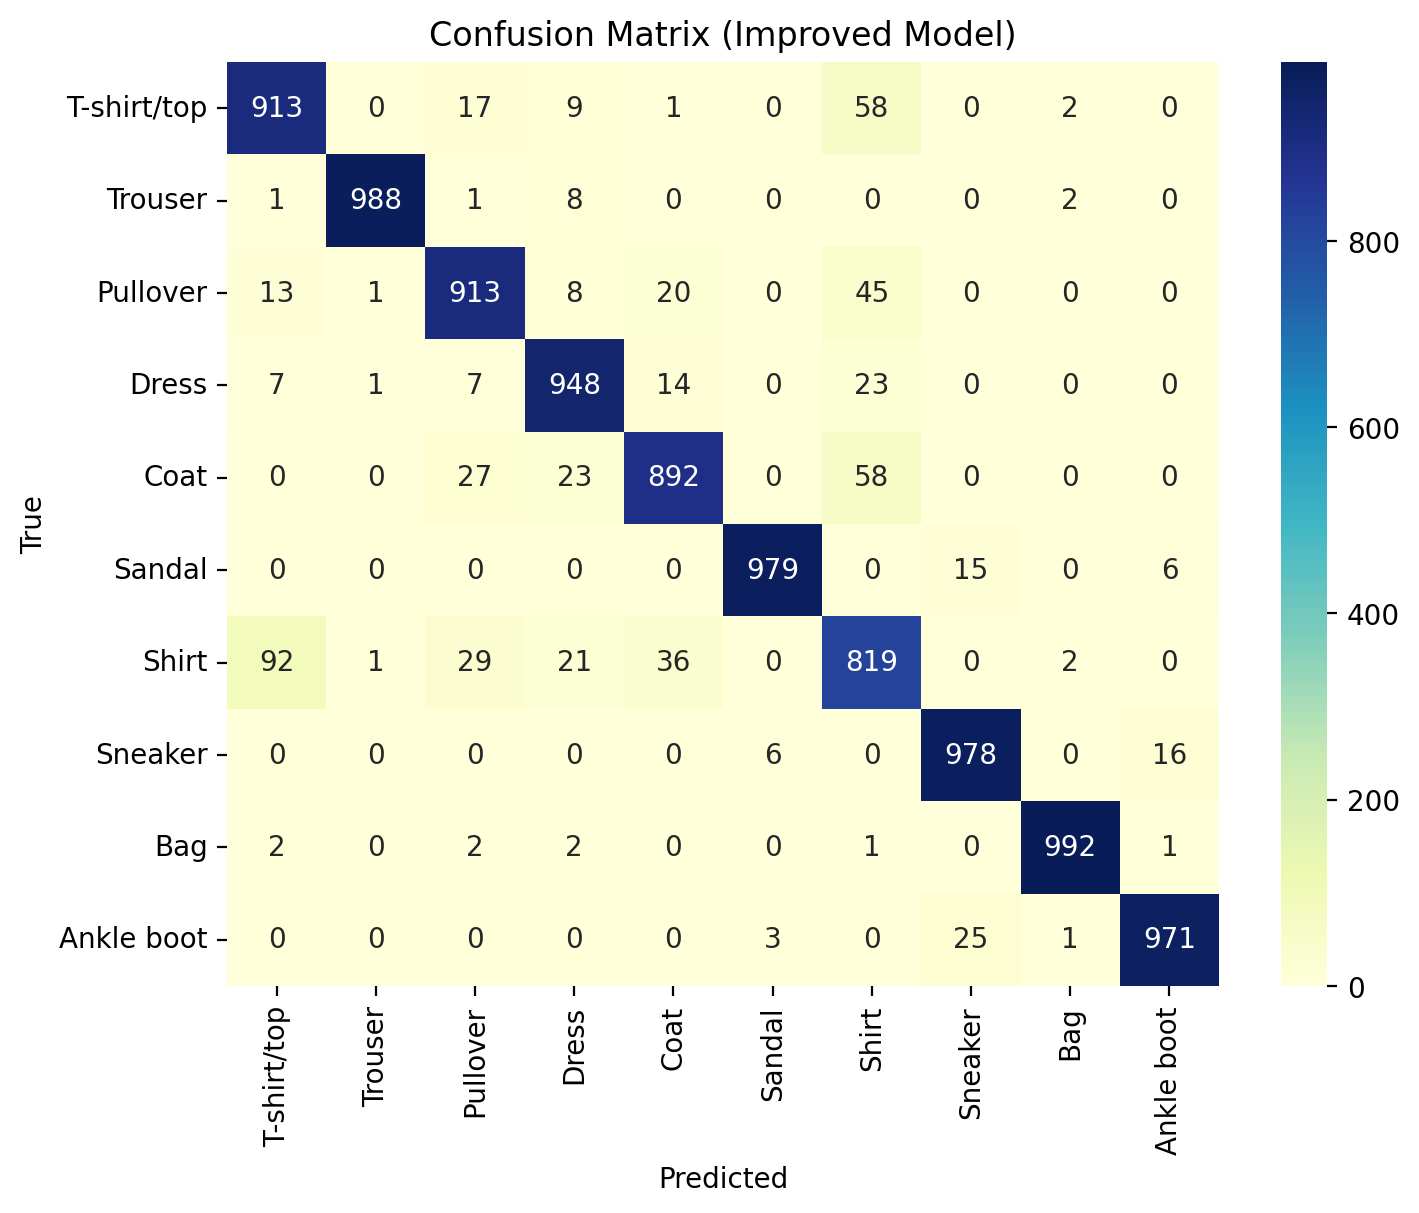

In [ ]:
# ===== 11. 예측 결과 분석 =====
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# ===== 12. 혼동 행렬 시각화 =====
cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix (Improved Model)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

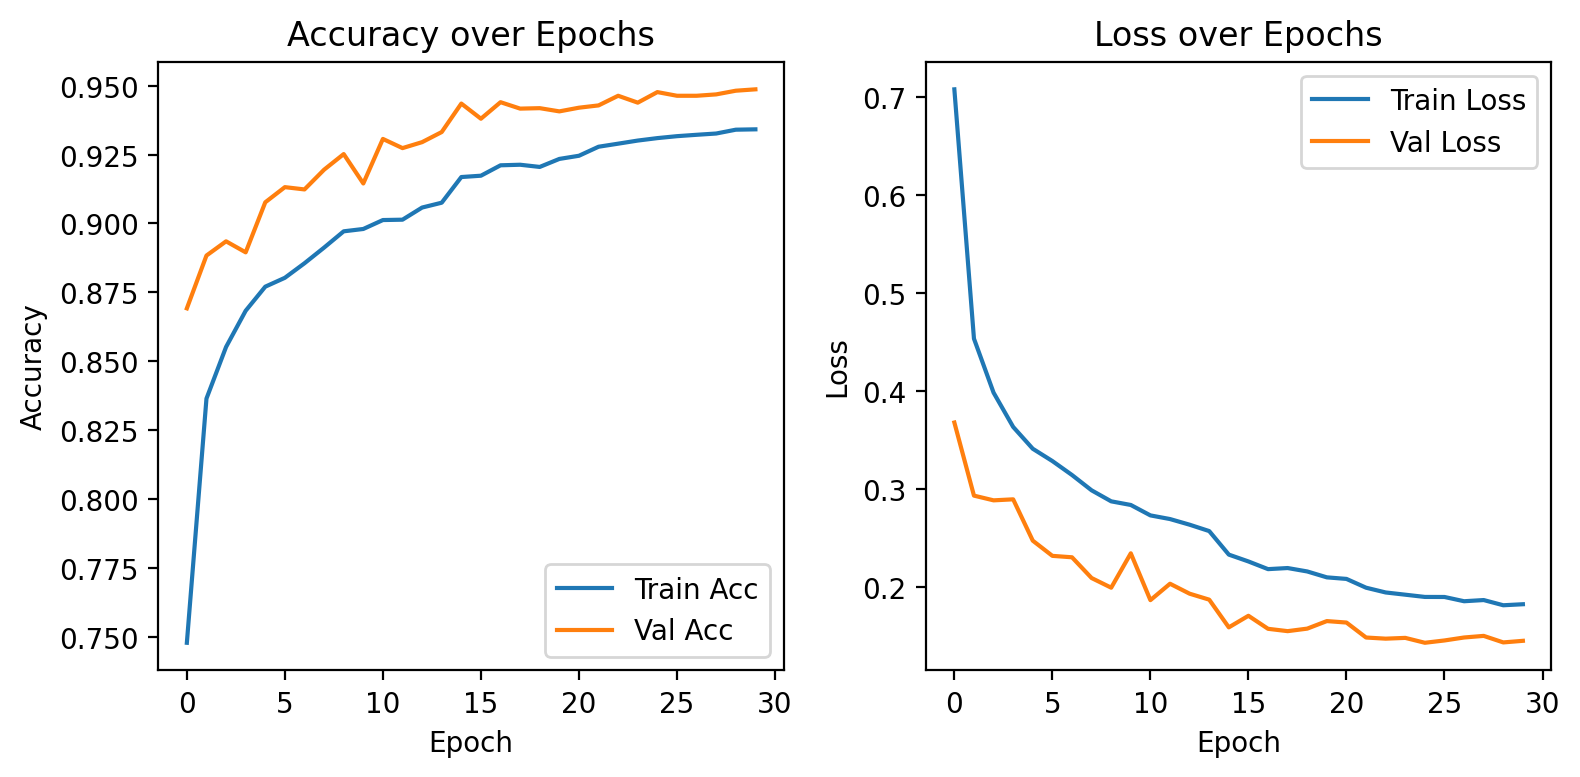

In [ ]:
# ===== 13. 학습 곡선 시각화 =====
plt.figure(figsize=(8, 4))

# 정확도
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# 손실
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

## 종료